<a href="https://colab.research.google.com/github/s3965610/COSC2671-A2/blob/asif_community_detection/community_detection_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Community detection based on language

In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import random
from pandas import json_normalize
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import networkx as nx
import community
from community import community_louvain
import random
import csv
import itertools
!pip install surprise
from surprise import accuracy
from collections import defaultdict
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, KNNBasic, KNNBaseline, SVD, AlgoBase
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut





Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 35.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633988 sha256=1ced65ae01e5e4d0807f4f33e59983d87183ba1d1af0901ea204a4b43c98eace
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## Recommender system Classes

In [2]:
class EData:
    def __init__(self, data, rankings):
        # Generate entire training set for evaluating properties 
        self.full_trainset = data.build_full_trainset()
        self.full_anti_testset = self.full_trainset.build_anti_testset()
        
        # Set rankings
        self.rankings = rankings
        
        # Generate a train (75) / test (25) split for measuring accuracy
        self.trainset, self.testset = train_test_split(data, test_size=0.25, random_state=1)
        
        # Create leave-one-out train/test split for eval of top-N recs
        # and we create an anti-test-set for generating predictions
        LOOCV = LeaveOneOut(n_splits=1, random_state=1)
        for train, test in LOOCV.split(data):
            self.LOOCVTrain = train
            self.LOOCVTest = test
        self.LOOCVAntiTestSet = self.LOOCVTrain.build_anti_testset()
        
        # Now compute sim matrix between users to measure diversity
        self.simAlgo = KNNBaseline(
            sim_options={'name': 'cosine', 'user_based': True}
        )
        self.simAlgo.fit(self.full_trainset)
        
        
    def get_full_trainset(self):
        return self.full_trainset
    
    def get_full_anti_testset(self):
        return self.full_anti_testset
    
    def get_trainset(self):
        return self.trainset
    
    def get_testset(self):
        return self.testset
    
    def get_LOOCV_testset(self):
        return self.LOOCVTest
    
    def get_LOOCV_trainset(self):
        return self.LOOCVTrain
    
    def get_LOOCV_anti_testset(self):
        return self.LOOCVAntiTestSet
    
    def get_rankings(self):
        return self.rankings
    
    def get_sims(self):
        return self.simAlgo

class Algorithm:
    
    def __init__(self, name, algorithm):
        self.name = name
        self.algo = algorithm
        
    def evaluate(self, eval_data):
        metrics = {}
        
        # Compute accuracy
        print("Evaluating accuracy...")
        self.algo.fit(eval_data.get_trainset())
        preds = self.algo.test(eval_data.get_testset())
        print(preds)
        metrics['RMSE'] = Metrics.RMSE(preds)
        metrics['MAE'] = Metrics.MAE(preds)
        
        # Eval top-10 via leave-one-out
        print("Evaluating top-10 with LOOCV..")
        self.algo.fit(eval_data.get_LOOCV_trainset())
        lo_preds = self.algo.test(eval_data.get_LOOCV_testset())
            
        # Generate preds for ratings not in training
        all_preds = self.algo.test(eval_data.get_LOOCV_anti_testset())
      
        # Get top 10 recs per user
        topN_preds = Metrics.get_topN(all_preds, 10)
        
        print('Evaluating rank metrics...')
        # Hit-rate - how often a repo that the user liked was recommended
        metrics['HR'] = Metrics.hit_rate(topN_preds, lo_preds)
        
        # Cumulative-hit-rate
        metrics['CHR'] = Metrics.cumulative_hit_rate(topN_preds, lo_preds)

        metrics["ARHR"] = Metrics.avg_reciprocal_hit_rate(topN_preds, lo_preds)

        print('Computing recs with complete dataset...')
        self.algo.fit(eval_data.get_full_trainset())
        all_preds = self.algo.test(eval_data.get_full_anti_testset())
        topN_preds = Metrics.get_topN(all_preds, 10)
        
        metrics['Coverage'] = Metrics.user_coverage(topN_preds, eval_data.get_full_trainset().n_users)
        metrics['Diversity'] = Metrics.diversity(topN_preds, eval_data.get_sims())
        metrics['Novelty'] = Metrics.novelty(topN_preds, eval_data.get_rankings())
        
        print('Done.')
        
        return metrics
        
        
class Evaluator:
    algorithms = []
    
    def __init__(self, data, rankings):
        self.data = EData(data, rankings)
    
    def add_algorithm(self, name, algorithm):
        self.algorithms.append(Algorithm(name, algorithm))
    
    def evaluate(self):
        results = {}
        for algo in self.algorithms:
            print(f'Evaluating {algo.name}...')
            results[algo.name] = algo.evaluate(self.data)
        
        # Display results
        print()
        print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Algorithm", "RMSE", "MAE", "HR", "CHR", "ARHR", "Coverage", "Diversity", "Novelty" ))

        for name, metrics in results.items():
                print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
                        name, metrics["RMSE"], metrics["MAE"], metrics["HR"], metrics["CHR"],  metrics["ARHR"], metrics["Coverage"], metrics["Diversity"], metrics["Novelty"]))
     
    
    
class Metrics:
    
    def MAE(predictions):
        return accuracy.mae(predictions, verbose=False)
    
    def RMSE(predictions):
        return accuracy.rmse(predictions, verbose=False)
    
    def get_topN(predictions, n=10):
        top_n = defaultdict(list)
        for uid, iid, actual, estimated, _ in predictions:
            if (estimated >= 2.0): # >1 is min rating
                top_n[int(uid)].append((int(iid), estimated))
                
        for uid, ratings in top_n.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[int(uid)] = ratings[:n]
        
        return top_n
        
    def hit_rate(top_n_preds, left_out_preds):
        """Determine the hit-rate (how good) of top-N list"""
        hits = 0
        total = 0
        for lo_pred in left_out_preds:
            lo_uid = lo_pred[0]
            lo_iid = lo_pred[1]
            
            # Check if in top 10
            is_hit = False
            for tn_iid, tn_pred in top_n_preds[int(lo_uid)]:
                if (int(lo_iid) == int(tn_iid)):
                    is_hit = True
                    break
            if is_hit:
                hits += 1
            total += 1
            
        precision = hits / total
        return precision
            
    
    def cumulative_hit_rate(topN_preds, left_out_preds):
        hits = 0
        total = 0
        for lo_uid, lo_iid, actual, estimated, _ in left_out_preds:
            if (actual >= 1.0): # Only look at things the user starred
                is_hit = False
                for tn_iid, tn_pred in topN_preds[int(lo_uid)]:
                    if (int(lo_iid) == tn_iid):
                        is_hit = True
                        break
                if is_hit:
                    hits += 1
                total += 1
        precision = hits/total
        return precision
    
    def avg_reciprocal_hit_rate(topN_preds, left_out_preds):
        S = 0
        total = 0
        for lo_uid, lo_iid, actual, estimated, _ in left_out_preds:
            hit_rank = 0
            rank = 0
            for tn_iid, tn_pred in topN_preds[int(lo_uid)]:
                rank += 1
                if (int(lo_iid) == tn_iid):
                    hit_rank = rank
                    break
            if hit_rank > 0:
                S += 1.0 / hit_rank
            total += 1
        return S / total
    
    def user_coverage(topN_preds, num_users):
        # Calc the percentage of users that have at least 1 good rec
        hits = 0
        for tn_uid in topN_preds.keys():
            is_hit = False
            for tn_iid, tn_pred in topN_preds[tn_uid]:
                if tn_pred >= 2.0: # Todo is 1 correct number to use??
                    is_hit = True
                    break
            if is_hit:
                hits += 1
        return hits / num_users
    
    
    # TODO: NOVELTY AND DIVERSITY ARE NOT WORKING -- most likely due to topN_preds not working??
    def diversity(topN_preds, sim_algorithm):
        n = 0
        total = 0
        mat = sim_algorithm.compute_similarities()
        for uid in topN_preds.keys():
            pairs = itertools.combinations(topN_preds[uid], 2)
            for pair in pairs:
                repo1 = pair[0][0]
                repo2 = pair[1][0]
                if sim_algorithm.trainset.knows_item(repo1) and sim_algorithm.trainset.knows_item(repo2):
                    inner_id1 = sim_algorithm.trainset.to_inner_iid(repo1) # used to be str(repo1)
                    inner_id2 = sim_algorithm.trainset.to_inner_iid(repo2)
                    sim = mat[inner_id1][inner_id2]
                    total += sim
                    n += 1
        return 1 - (total / n) 
    
    def novelty(topN_preds, rankings):
        n = 0
        total = 0
        for uid in topN_preds.keys():
            for rating in topN_preds[uid]:
                iid = rating[0]
                rank = rankings[iid]
                total += rank
                n += 1
        return total / n

## Data Preparation

In [3]:
# directory must be changed to local from google drive
with open("/content/drive/MyDrive/data/user_info.json", "r") as read_file:
    user_infos = json.load(read_file)
with open("/content/drive/MyDrive/data/user-items-ratings-improved.csv", "r") as read_file:
    user_item_data = pd.read_csv(read_file)

In [4]:
user_item_data.head(5)

,user_id,repo_id,rating
0,0x00evil,SwiftGGTeam/the-swift-programming-language-in-...,2
1,0x00evil,atom/atom,3
2,0x00evil,capistrano/capistrano,3
3,0x00evil,git/git,3
4,0x00evil,golang/go,3


In [5]:
language_dict = {}
for i in user_infos:
    language_dict[i] = []
    nodes = []
    if( user_infos[i]['data']!= None):
        nodes = user_infos[i]['data']['user']['repositories']['nodes']
        
    for n in nodes:
        if(n['primaryLanguage'] != None):
            
            language_dict[i].append(n['primaryLanguage']['name'])
        
 
        # language_dict[i].append(n['primaryLanguage']['name'])
languages = []
for key, val in language_dict.items():
    language_dict[key] = set(val)
    languages.extend(val)
languages = set(languages)


## Create graph
Graph is created by building an edge if two users have common languages used in their repositories. The wieght of the edge is the number of common programming languages used

In [6]:
G = nx.Graph()

# TODO: Remember to import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import random
# TODO: for you to complete!
# use networkx to draw

users = list(language_dict.keys())

count = 0
for i in range(len(users) - 1):
    user = users[i]
    for j in range(i + 1, len(users)):
        user2 = users[j]
        common_languages = language_dict[user].intersection(language_dict[user2])
        if(len(common_languages) > 0):
            count += 1
            G.add_edge(user,  user2, weight = len(common_languages))


In [7]:
print("Graph size: ", count)

Graph size:  1221167


In [8]:
partition = community_louvain.best_partition(G)
print('Modularity of best partition: ', community_louvain.modularity(partition, G))

Modularity of best partition:  0.12289526498181881


## Visualise the graph

In [9]:
comms_dict = {}
# generate comms distionary
for lComms in set(partition.values()) :
    comms_dict[lComms] = [nodes for nodes in partition.keys() if partition[nodes] == lComms]

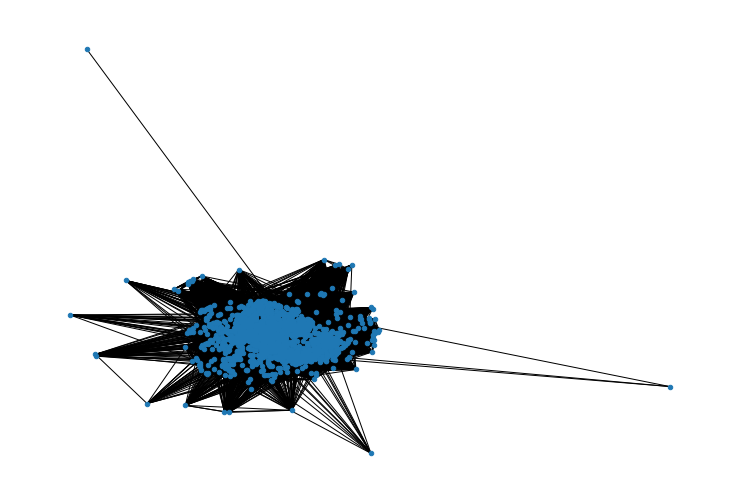

In [10]:
# code reference: https://www.kaggle.com/code/kevinvdsk/community-detection

# Draw graph
plt.figure(figsize=(13, 9))
n_partition = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for val in comms_dict.values() :
    nx.draw_networkx_nodes(G, pos, val, node_size = 20)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()



## Form Communities

In [11]:
# heuristic approach to Louvain algorithm as 
# described here https://perso.crans.org/aynaud/communities/
centers = {}
communities = {}
G_copy = G.copy()
min_nb = 30
community_list = []
for lComms , nodes in comms_dict.items() :
    
    if len(nodes) < min_nb:
        G_copy.remove_nodes_from(nodes)
    else:
        
        subgraph = G_copy.subgraph(nodes)
        d = nx.degree_centrality(subgraph)
        comm_name = max(d, key=d.get)
        centers[comm_name] = lComms
        communities[lComms] = comm_name
        community_list.append(nodes)
        print('Community name ', comm_name, '(clusId ', lComms, ') - ', len(nodes), ' users:')
        print(nodes, '\n')

Community name  mataralhawiti (clusId  0 ) -  749  users:
['jheins3', 'jiguorui', 'jimmystelzer', 'jmsykes15', 'jodfie', 'jodyford', 'johan--', 'jokemilk', 'jorfde', 'jorgevila', 'judell', 'juicelite', 'justBanks', 'justinjohn0306', 'jwballan', 'k0544530931', 'kaloprominat', 'kaloyan', 'kamino', 'kankungyip', 'kapilt', 'karimmd', 'karthiksripal', 'kaschubert', 'kayiwa', 'kcmvp', 'kenhehuang', 'keon', 'kerbrose', 'khalidmarescalchi', 'kilbee', 'killua001', 'kjaft', 'knittledan', 'koenvo', 'kondalrao', 'kounch', 'kozo2', 'kreely', 'krishnakumar4a4', 'kroggen', 'kvmc', 'kycent', 'l10xbin', 'lafengnan', 'laonger', 'lastnamelefty', 'laurencecao', 'leeyisoft', 'lendo', 'leonlai', 'levocode', 'lgnq', 'lin7sh', 'linhx13', 'lipchanskiy', 'lisai9093', 'littlebearz', 'litvinovmitch11', 'liudhzhyym', 'liugangnhm', 'liuzl', 'liverbool', 'livestalker', 'ljyong2010', 'lmommaerts', 'loftwah', 'loki-sama', 'lorenzofilizola', 'loyning', 'lukepistrol', 'lulucca12', 'lxb1628', 'ly0', 'machorro', 'maddanio

## Visualise communities

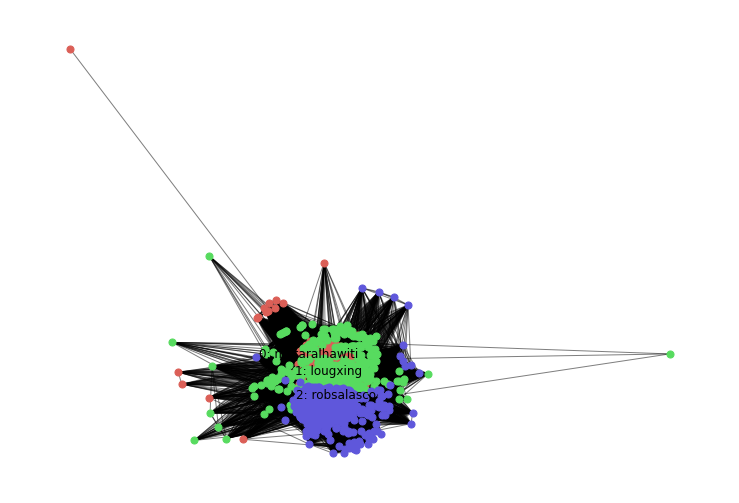

In [12]:

import seaborn as sns
# Display graph
# code reference: https://www.kaggle.com/code/kevinvdsk/community-detection
# Display graph
plt.figure(figsize=(13, 9))
node_size = 50
count = 0
pos = nx.spring_layout(G_copy)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_copy, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_copy, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_copy, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_copy, pos, labels)
plt.axis('off')
plt.show()



## Community induced graph

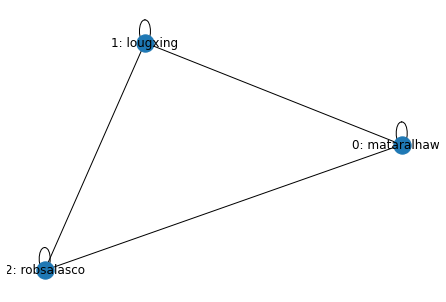

In [36]:



# Display induced graph
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community_louvain.induced_graph(nodes_main_com, G_copy)

pos_ind = nx.spring_layout(ind)
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind,  labels=labels)
plt.show()



## Language in each community

In [63]:
sns.set_theme(style="whitegrid")
def plot_com_language(com_list):
    language0 = []
    for user in com_list:
        language0.extend(list(language_dict[user]))
    lang_df = pd.DataFrame (language0, columns = ['language'])
    sns.countplot(x = 'language', data = lang_df, order=lang_df.language.value_counts().iloc[:5].index)

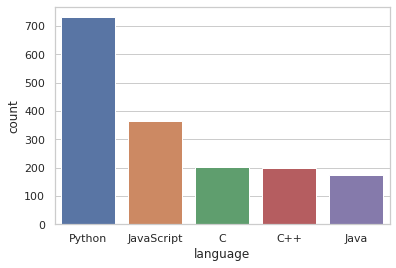

In [64]:
plot_com_language(community_list[0])



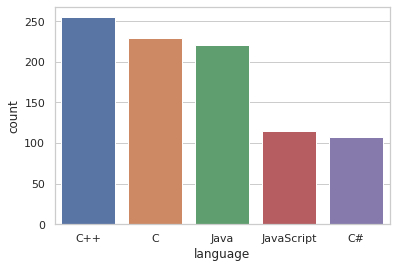

In [65]:
plot_com_language(community_list[1])

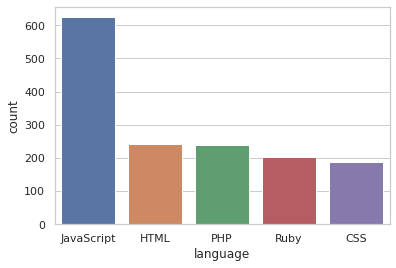

In [66]:
plot_com_language(community_list[2])

## Recommender system evaluation

In [ ]:
c0_df = user_item_data[user_item_data['user_id'].isin(community_list[0])]
c1_df = user_item_data[user_item_data['user_id'].isin(community_list[1])]
c2_df = user_item_data[user_item_data['user_id'].isin(community_list[2])]


In [23]:
def evaluate_rec_sys(df):


    repo_rankings = df.groupby(['repo_id']).rating.sum().sort_values(ascending=False)
    


    temp = df.copy()
    # temp['rating'] = temp['rating']+1

    temp['user_id'] = temp['user_id'].astype('category')
    temp['repo_id'] = temp['repo_id'].astype('category')

    # ulabels, ulevels = pd.factorize(temp['user_id'])
    # rlabels, rlevels = pd.factorize(temp['repo_id'])
    temp = pd.DataFrame({
        'user_name': temp['user_id'],
        'user_id': temp['user_id'].cat.codes,
        'repo_name': temp['repo_id'],
        'repo_id': temp['repo_id'].cat.codes,
        'rating': temp['rating']
    })

    reader = Reader(rating_scale=(1, 3))
    data = Dataset.load_from_df(temp[['user_id', 'repo_id', 'rating']], reader)

    # setup an evaluator
    evaluator = Evaluator(data, repo_rankings)

    evaluator.algorithms = []

    # USER-BASED KNN
    user_knn = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})

    # SVD
    svd = SVD()

   
    evaluator.add_algorithm('User KNN', user_knn)
    evaluator.add_algorithm('SVD', svd)


    # Run the evals
    evaluator.evaluate()




In [20]:
evaluate_rec_sys(c0_df)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating User KNN...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
[Prediction(uid=9, iid=115, r_ui=3.0, est=2.1968807935341577, details={'actual_k': 5, 'was_impossible': False}), Prediction(uid=236, iid=194, r_ui=1.0, est=2.0, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid=389, iid=108, r_ui=3.0, est=2.390625, details={'actual_k': 5, 'was_impossible': False}), Prediction(uid=110, iid=137, r_ui=2.0, est=1.823580421274817, details={'actual_k': 13, 'was_impossible': False}), Prediction(uid=298, iid=29, r_ui=3.0, est=1.75, details={'actual_k': 4, 'was_impossible': False}), Prediction(uid=304, iid=80, r_ui=1.0, est=1.8917346119057241, details={'actual_k': 16, 'was_impossible': False}), Prediction(uid=79, iid=158, r_ui=1.0, est=1.9801321052592176, details={'actual_k': 6, 'was_impossible': False}), Prediction(uid=

In [24]:
evaluate_rec_sys(c1_df)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating User KNN...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
[Prediction(uid=120, iid=65, r_ui=3.0, est=1.981629392971246, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}), Prediction(uid=108, iid=135, r_ui=3.0, est=1, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=231, iid=168, r_ui=2.0, est=1.981629392971246, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}), Prediction(uid=218, iid=3, r_ui=3.0, est=2.0, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid=214, iid=205, r_ui=3.0, est=1, details={'actual_k': 4, 'was_impossible': False}), Prediction(uid=242, iid=108, r_ui=1.0, est=2.5, details={'actual_k': 2, 'was_impossible': False}), Prediction(uid=166, iid=79, r_ui=1.0, est=3, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid

IndexError: ignored

In [22]:
evaluate_rec_sys(c2_df)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating User KNN...
Evaluating accuracy...
Computing the cosine similarity matrix...
Done computing similarity matrix.
[Prediction(uid=70, iid=95, r_ui=1.0, est=2.080451935537528, details={'actual_k': 12, 'was_impossible': False}), Prediction(uid=443, iid=173, r_ui=1.0, est=2.024026329460356, details={'actual_k': 8, 'was_impossible': False}), Prediction(uid=281, iid=122, r_ui=2.0, est=2.156363907256924, details={'actual_k': 7, 'was_impossible': False}), Prediction(uid=90, iid=136, r_ui=2.0, est=1.9115182325110558, details={'actual_k': 10, 'was_impossible': False}), Prediction(uid=258, iid=6, r_ui=1.0, est=3, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid=357, iid=202, r_ui=1.0, est=3, details={'actual_k': 1, 'was_impossible': False}), Prediction(uid=72, iid=41, r_ui=2.0, est=1.8, details={'actual_k': 5, 'was_impossible': False}), Prediction(uid=360, iid=103, 